In [1]:
import treecorr
import GCRCatalogs
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import healpy as hp
import camb
import camb.correlations
import matplotlib.colors as clr
%matplotlib inline

In [2]:
def kk_correlation(zlo, zhi):
    kk = treecorr.KKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(100./60)*(np.pi/180))
    
    mask_redshift = (data['redshift']>zlo)*(data['redshift']<zhi) #the foreground shear?
    ra0 = data['ra'][mask_redshift]
    dec0 = data['dec'][mask_redshift]
    
    #restrict galaxies to the same octant where we have Kcmb data (in degrees)
    mask_K = (ra0>0)*(ra0<90)*(dec0<0)
    ra_K = ra0[mask_K]
    dec_K = dec0[mask_K]
    
    cat_K = treecorr.Catalog(ra=ra0, dec=dec0, ra_units='deg', dec_units='deg', k=data['convergence'][mask_redshift][mask_K])
    
    kk.process(cat_K_cmb, cat_K)
    xi = kk.xi
    R = np.exp(kk.logr)
    return xi, R

In [19]:
def theory_real_cross(lmax2, z_vals, n_vals, xvals):
    ''' Compute the correlation between galaxy shear and CMB lensing in real space '''
    ns = 0.963
    s8 = .8

    Omega_c = .22
    Omega_b = .0045
    h = 71./100.

    cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8 = s8, n_s = ns)#, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    cmbl1 = ccl.CMBLensingTracer(cosmo_ccl, 1100) # second number is source redshift
    lens1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(z_vals, n_vals))
    ll = np.arange(lmax2)

    num = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(z_vals, n_vals), bias = (z_vals,np.ones(len(z_vals))*1.0))
    #cls = ccl.angular_cl(cosmo_ccl, cmbl1, cmbl1, ll)
    cls = ccl.angular_cl(cosmo_ccl, lens1, cmbl1, ll) #gk
    cls_num = ccl.angular_cl(cosmo_ccl,num,cmbl1,ll) #nk
    win = hp.pixwin(4096)[:lmax2]
    cls = cls*win**2
    pp3_2 = np.zeros((lmax2, 4))
    pp3_2[:, 0] = cls[:] * (ll * (ll + 1.)) / (2. * np.pi)
    cxvals = np.cos(xvals / (60.) / (180. / np.pi))
    vals = camb.correlations.cl2corr(pp3_2, cxvals)#from fourier space to real space
    #cls_num = cls_num*win**2
    pp3_2 = np.zeros((lmax2, 4))
    pp3_2[:, 0] = cls_num[:] * (ll * (ll + 1.)) / (2. * np.pi)
    cxvals = np.cos(xvals / (60.) / (180. / np.pi))
    vals2 = camb.correlations.cl2corr(pp3_2, cxvals)
    return xvals, vals[:, 0], vals2[:, 0]

In [4]:
filename = '/global/projecta/projectdirs/lsst/groups/CS/cosmoDC2/mass_sheets_behind_z3/cmb_maps/cmblensmap_total_gausshiz_masked.fits'

In [5]:
mapfile = hp.read_map(filename)
print(len(mapfile))

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
201326592


In [6]:
index = np.arange(201326592)

In [7]:
theta, phi = hp.pix2ang(nside=4096, ipix=index)
mask_kcmb = (phi>0)*(phi<np.pi/2)*(theta>np.pi/2)
print(True in mask_kcmb)

True


In [8]:
kcmb = mapfile[mask_kcmb]
ra_K = phi[mask_kcmb]
dec_K = np.pi/2-theta[mask_kcmb]
print(kcmb)

[ 0.00170215  0.09302823  0.09426145 ... -0.06422222 -0.12017739
 -0.09952184]


In [9]:
cat_K_cmb = treecorr.Catalog(ra=ra_K, dec=dec_K, k=kcmb, ra_units='rad', dec_units='rad')

In [31]:
gc = GCRCatalogs.load_catalog('cosmoDC2')

In [32]:
data = gc.get_quantities(['ra', 'dec', 'convergence', 'redshift'], filters=['mag_r_lsst<28'])

In [33]:
redshift = np.linspace(0.5, 3, 6)
print(redshift)

[0.5 1.  1.5 2.  2.5 3. ]


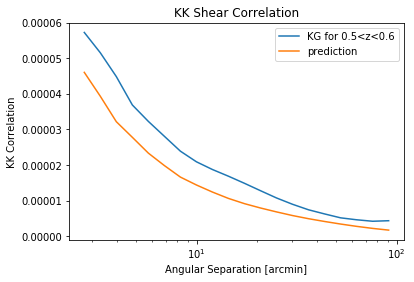

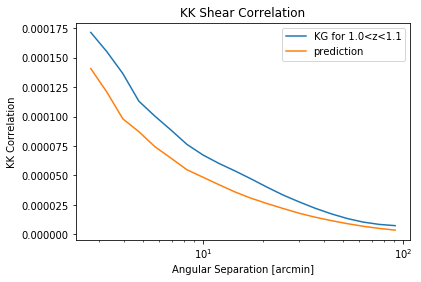

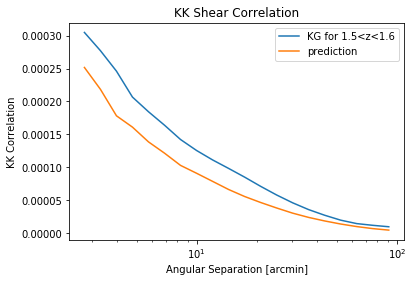

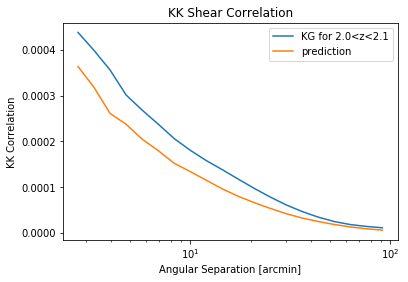

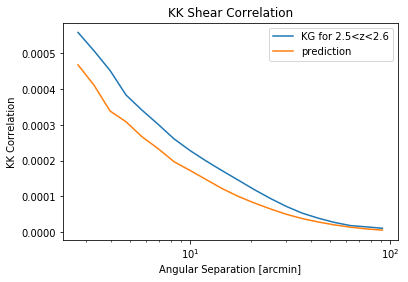

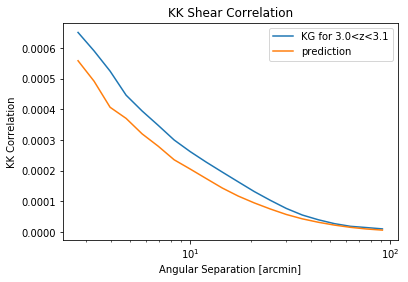

In [35]:
for z in redshift:
    xi, R = kk_correlation(z, z+0.1)
    R = np.degrees(R)
    mask = (data['redshift']<z+0.1)*(data['redshift']>z)
    n_vals, z_vals = np.histogram(data['redshift'][mask], bins=200)
    z_vals = (z_vals[1:] - z_vals[:-1]) / 2. + z_vals[:-1]
    theta, kk, nk = theory_real_cross(10000, z_vals, n_vals, R*60.)
    plt.semilogx(R*60, xi, label='KG for '+str(round(z,1))+'<z<'+str(round(z+0.1,1)))
    plt.semilogx(R*60, kk, label='prediction')
    plt.legend()
    plt.xlabel('Angular Separation [arcmin]')
    plt.ylabel('KK Correlation')
    plt.title('KK Shear Correlation')
    plt.savefig('KK_Correlation.png', dpi=200)
    plt.show()

In [20]:
mask = (data['redshift']<3+0.1)*(data['redshift']>3)

In [21]:
print(True in mask)

False


(array([1.0570e+03, 4.6930e+03, 5.3730e+03, 7.2360e+03, 9.0780e+03,
        6.3950e+03, 8.2940e+03, 1.9947e+04, 1.7576e+04, 1.8666e+04,
        1.6456e+04, 1.5290e+04, 2.0028e+04, 2.0737e+04, 2.3950e+04,
        2.0036e+04, 1.7464e+04, 1.4994e+04, 1.7597e+04, 1.7914e+04,
        1.8799e+04, 1.4162e+04, 1.3367e+04, 1.2227e+04, 1.2429e+04,
        1.0312e+04, 7.8090e+03, 7.8290e+03, 7.7220e+03, 6.2930e+03,
        4.9690e+03, 4.5550e+03, 4.2190e+03, 2.8830e+03, 2.4570e+03,
        2.3760e+03, 2.0460e+03, 2.2670e+03, 2.4490e+03, 9.8200e+02,
        1.2980e+03, 1.6630e+03, 1.8140e+03, 1.0730e+03, 8.9700e+02,
        6.5000e+02, 9.6700e+02, 5.6100e+02, 4.6000e+02, 9.4700e+02,
        6.8000e+02, 3.1700e+02, 7.7500e+02, 6.2900e+02, 3.0100e+02,
        3.1700e+02, 1.5100e+02, 1.8400e+02, 9.9000e+01, 2.7800e+02,
        2.0300e+02, 1.3900e+02, 7.7000e+01, 5.3000e+01, 1.2500e+02,
        3.8000e+01, 1.3000e+01, 1.4000e+01, 2.8000e+01, 2.5000e+01,
        1.4000e+01, 2.1000e+01, 2.5000e+01, 1.90

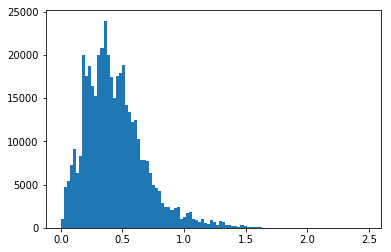

In [28]:
plt.hist(data['redshift'], bins=100)